In [ ]:
!pip install torchinfo monai pytorch_lightning efficientnet-pytorch medmnist -q

In [ ]:
import os
import math
import pandas as pd
import torch
import random
import logging
import torchinfo
import pytorch_lightning as pl
from pprint import pprint
from torch import nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import STL10
from transformers import BertModel, BertTokenizer
from efficientnet_pytorch import EfficientNet
from monai.losses import ContrastiveLoss
import matplotlib.pyplot as plt
import numpy as np
import medmnist
from medmnist import INFO, OrganAMNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger

In [ ]:
loggers = [logging.getLogger(name) for name in logging.root.manager.loggerDict]
for logger in loggers:
    if "transformers" in logger.name.lower():
        logger.setLevel(logging.ERROR)

In [ ]:
hparams = {"emb_size": 768,
           "batch_size": 4,
           "lr": 1e-4,
           "wd": 1e-5,
           "max_epochs": 10,
           "patience": 2,
           "num_workers": 1,
           "text_model_string": "emilyalsentzer/Bio_ClinicalBERT",
           "freeze_text_model": True,
           "image_model_string": "efficientnet-b0",
           "freeze_image_model": False,
           "size": 128}

In [ ]:
class MyOrganMNIST(Dataset):
    def __init__(self, mode, transform, size):
        print("Initializing OrganMNIST...")

        os.makedirs("./data", exist_ok=True)
        self.dataset = OrganAMNIST(root="./data", split='train' if mode == "train" else "test", transform=transform, download=True, size=size)

        print("Loading tokenizer...")
        self.tokenizer = BertTokenizer.from_pretrained(hparams["text_model_string"])
        print(f"Initialized {mode} organ mnist data.")
        self.metadata = INFO["organamnist"]
        pprint(self.metadata)
        self.classes = self.metadata["label"]

        max_length = 0
        for label in self.classes.values():
            tokens = self.tokenizer(label)["input_ids"]
            max_length = max(max_length, len(tokens))
        self.max_length = max_length
        print(f"Max label token length: {self.max_length}")

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, i):
        image, label = self.dataset[i]

        image = image.expand(3, -1, -1)

        # For some reason the label is a list
        assert len(label) == 1
        label = str(label[0])

        text = self.classes[label]

        text_tokens = self.tokenizer(text, return_tensors="pt", max_length=self.max_length, padding="max_length")["input_ids"][0]

        return {"image": image,
                "label": label,
                "text": text,
                "text_tokens": text_tokens}


class OrganMNISTDataModule(pl.LightningDataModule):
    MEAN = [0.5]
    STD = [0.5]
    def __init__(self, hparams):
        super().__init__()
        self.save_hyperparameters(hparams)
        self.transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=OrganMNISTDataModule.MEAN, std=OrganMNISTDataModule.STD)])

    def setup(self, stage):
        if stage == "fit":
            # Download and load the training data
            self.train = MyOrganMNIST("train", self.transform, self.hparams["size"])
            self.val = MyOrganMNIST("val", self.transform, self.hparams["size"])

    def train_dataloader(self):
        return DataLoader(self.train, batch_size=self.hparams["batch_size"], shuffle=True, num_workers=self.hparams["num_workers"])

    def val_dataloader(self):
        return DataLoader(self.val, batch_size=self.hparams["batch_size"], shuffle=False, num_workers=self.hparams["num_workers"])


In [ ]:
# Get some random training images
debug_datamodule = OrganMNISTDataModule(hparams)
debug_datamodule.prepare_data()
debug_datamodule.setup("fit")
debug_dataloader = debug_datamodule.train_dataloader()

Initializing OrganMNIST...
Using downloaded and verified file: ./data/organamnist_128.npz
Loading tokenizer...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Initialized train organ mnist data.
{'MD5': '68e3f8846a6bd62f0c9bf841c0d9eacc',
 'MD5_128': 'eeae80d0a227a8d099027e1b3cfd3b60',
 'MD5_224': '50747347e05c87dd3aaf92c49f9f3170',
 'MD5_64': '2dcccc29b88e6da5a01161ef20cda288',
 'description': 'The OrganAMNIST is based on 3D computed tomography (CT) '
                'images from Liver Tumor Segmentation Benchmark (LiTS). It is '
                'renamed from OrganMNIST_Axial (in MedMNIST v1) for '
                'simplicity. We use bounding-box annotations of 11 body organs '
                'from another study to obtain the organ labels. '
                'Hounsfield-Unit (HU) of the 3D images are transformed into '
                'gray-scale with an abdominal window. We crop 2D images from '
                'the center slices of the 3D bounding boxes in axial views '
                '(planes). The images are resized into 1×28×28 to perform '
                'multi-class classification of 11 body organs. 115 and 16 CT '
                

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


tensor([ 101,  188, 7136, 1424,  102,    0,    0])
tensor([ 101,  188, 7136, 1424,  102,    0,    0])
tensor([  101, 13093,   118,  1268,   102,     0,     0])
tensor([  101, 13093,   118,  1286,   102,     0,     0])


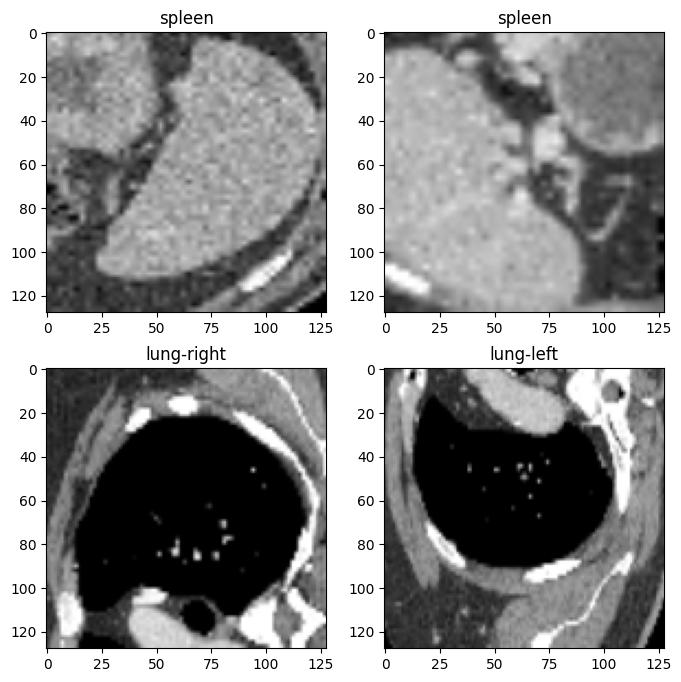

tensor([  101, 16042,   118,  1286,   102,     0,     0])
tensor([ 101,  175, 5521, 2149,  118, 1286,  102])
tensor([  101, 28083,   102,     0,     0,     0,     0])
tensor([  101, 13093,   118,  1286,   102,     0,     0])


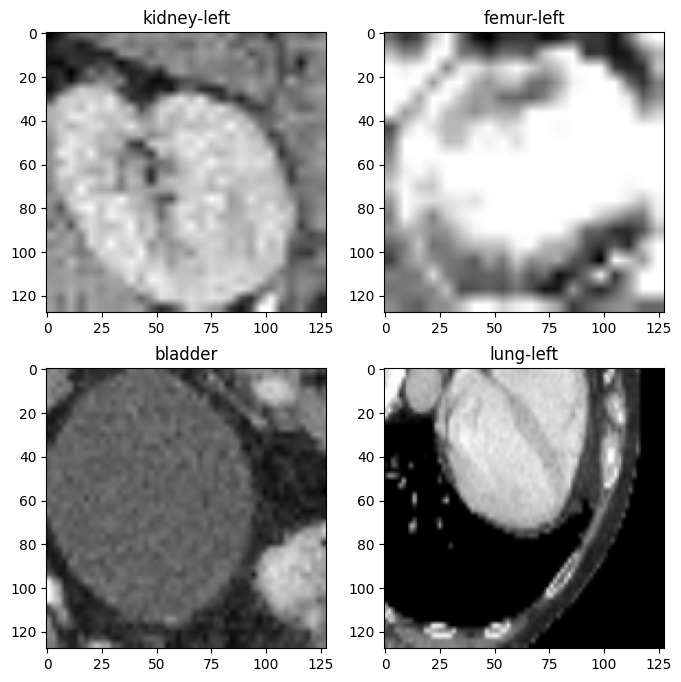

In [ ]:
N_BATCHES_TO_DISPLAY = 2
for j, batch in enumerate(debug_dataloader):
    if j >= N_BATCHES_TO_DISPLAY:
        break
    B = batch["image"].shape[0]
    square_side = math.isqrt(B)
    plt.figure(figsize=(8, 8))
    for i, (image, text, tokens) in enumerate(zip(batch["image"], batch["text"], batch["text_tokens"])):
        visual_image = (image - image.min())/(image.max() - image.min())
        plt.subplot(square_side, square_side, i + 1)
        plt.imshow(visual_image.permute(1, 2, 0), cmap="gray")
        plt.title(text)
        pprint(tokens)
    plt.show()


In [ ]:
class ImageModel(nn.Module):
    def __init__(self, hparams):
        super().__init__()
        self.image_model = EfficientNet.from_pretrained(hparams["image_model_string"])

        if hparams["freeze_image_model"]:
            print("Freezing image model")
            for param in self.image_model.parameters():
                param.requires_grad = False

        # Projection weights are not frozen
        self.image_model._fc = nn.Linear(self.image_model._fc.in_features, hparams["emb_size"])

    def forward(self, x):
        return self.image_model(x)

In [ ]:
class TextModel(nn.Module):
    def __init__(self, hparams):
        super().__init__()
        if hparams["freeze_text_model"]:
            print("Freezing text model")
            self.text_model = BertModel.from_pretrained(hparams["text_model_string"])
            for param in self.text_model.parameters():
                param.requires_grad = False

    def forward(self, **kwargs):
        return self.text_model(**kwargs).last_hidden_state.mean(dim=1)

In [ ]:
torchinfo.summary(TextModel(hparams), depth=1)

Freezing text model


Layer (type:depth-idx)                                       Param #
TextModel                                                    --
├─BertModel: 1-1                                             (108,310,272)
Total params: 108,310,272
Trainable params: 0
Non-trainable params: 108,310,272

In [ ]:
torchinfo.summary(ImageModel(hparams), depth=1)

Loaded pretrained weights for efficientnet-b0


Layer (type:depth-idx)                                  Param #
ImageModel                                              --
├─EfficientNet: 1-1                                     4,991,356
Total params: 4,991,356
Trainable params: 4,991,356
Non-trainable params: 0

In [ ]:
class LightningModule(pl.LightningModule):
    def __init__(self, hparams):
        super().__init__()
        self.save_hyperparameters(hparams)
        self.image_model = ImageModel(hparams)
        self.text_model = TextModel(hparams)
        self.tokenizer = BertTokenizer.from_pretrained(hparams["text_model_string"])

        # É possível melhor performance com ContrastiveLoss?
        self.loss = nn.MSELoss()

    def forward(self, batch):
        image_repr = self.image_model(batch["image"])

        tokens = batch["text_tokens"]

        text_repr = self.text_model(input_ids=tokens)

        # Que tipos de asserts poderíamos fazer aqui para garantir que a representação
        # textual e da imagem estão corretas?
        assert image_repr.shape == text_repr.shape, "Incorrect latent space shape"

        return_dict = {}
        return_dict["loss"] = self.loss(image_repr, text_repr)
        return_dict["image_repr"] = image_repr
        return_dict["text_repr"] = text_repr

        return return_dict

    def query(self, query: str, image_batch):
        assert isinstance(query, str), 'Query must be a single string'

        # Tokenize and obtain text representation (shape: [1, D])
        tokens = self.tokenizer(query, return_tensors="pt", padding=True, truncation=True)

        # Shape: [D]
        text_repr = self.text_model(**tokens).squeeze(0)

        # Generate image representations (shape: [B, D])
        image_reprs = self.image_model(image_batch)

        # Expand text_repr to match the batch size of image_reprs. No copy done.
        text_repr_expanded = text_repr.unsqueeze(0).expand(image_reprs.size(0), -1)

        # Calculate similarities
        similarities = torch.cosine_similarity(text_repr_expanded, image_reprs)

        # Return what is the top-1 image
        index = similarities.argmax()

        return similarities, index

    def training_step(self, batch, batch_idx):
        outputs = self.forward(batch)
        loss = outputs["loss"]
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)

        return loss

    def validation_step(self, batch, batch_idx):
        outputs = self.forward(batch)
        loss = outputs["loss"]

        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)

        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.hparams["lr"], weight_decay=self.hparams["wd"])

        return optimizer

In [ ]:
# Debug query module
lightning_module = LightningModule(hparams)
sample_batch = torch.ones(size=(2, 3, 224, 224))
sample_texts = ["Hello World", "Apple"]
query = "Hello!"
lightning_module.query(query, sample_batch)

del lightning_module
del sample_batch
del sample_texts
del query

Loaded pretrained weights for efficientnet-b0
Freezing text model


In [ ]:
lightning_module = LightningModule(hparams)
datamodule = OrganMNISTDataModule(hparams)

# Early Stopping
early_stop_callback = EarlyStopping(monitor='val_loss',
                                    patience=hparams["patience"],
                                    verbose=True,
                                    mode='min')

# Model Checkpoint
checkpoint_callback = ModelCheckpoint(monitor='val_loss',
                                      dirpath='/content/drive/MyDrive/Diedre - posdoc/Mini-curso CBEB/Notebooks/artifacts/checkpoints2',
                                      filename='medical_embedding_search-weight-{epoch}-{val_loss:.2f}',
                                      save_top_k=1,
                                      mode='min')

# CSV Logger
csv_logger = CSVLogger("logs", name="model")

# Trainer with callbacks and logger
trainer = pl.Trainer(callbacks=[early_stop_callback, checkpoint_callback],
                     logger=csv_logger,
                     max_epochs=hparams["max_epochs"],
                     accelerator="cpu",
                     devices=1)

Loaded pretrained weights for efficientnet-b0
Freezing text model


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(lightning_module, datamodule)

Initializing OrganMNIST...
Using downloaded and verified file: ./data/organamnist_128.npz
Loading tokenizer...
Initialized train organ mnist data.
{'MD5': '68e3f8846a6bd62f0c9bf841c0d9eacc',
 'MD5_128': 'eeae80d0a227a8d099027e1b3cfd3b60',
 'MD5_224': '50747347e05c87dd3aaf92c49f9f3170',
 'MD5_64': '2dcccc29b88e6da5a01161ef20cda288',
 'description': 'The OrganAMNIST is based on 3D computed tomography (CT) '
                'images from Liver Tumor Segmentation Benchmark (LiTS). It is '
                'renamed from OrganMNIST_Axial (in MedMNIST v1) for '
                'simplicity. We use bounding-box annotations of 11 body organs '
                'from another study to obtain the organ labels. '
                'Hounsfield-Unit (HU) of the 3D images are transformed into '
                'gray-scale with an abdominal window. We crop 2D images from '
                'the center slices of the 3D bounding boxes in axial views '
                '(planes). The images are resized into 1×28×

INFO:pytorch_lightning.callbacks.model_summary:
  | Name        | Type       | Params | Mode 
---------------------------------------------------
0 | image_model | ImageModel | 5.0 M  | train
1 | text_model  | TextModel  | 108 M  | train
2 | loss        | MSELoss    | 0      | train
---------------------------------------------------
5.0 M     Trainable params
108 M     Non-trainable params
113 M     Total params
453.207   Total estimated model params size (MB)
252       Modules in train mode
228       Modules in eval mode


Initialized val organ mnist data.
{'MD5': '68e3f8846a6bd62f0c9bf841c0d9eacc',
 'MD5_128': 'eeae80d0a227a8d099027e1b3cfd3b60',
 'MD5_224': '50747347e05c87dd3aaf92c49f9f3170',
 'MD5_64': '2dcccc29b88e6da5a01161ef20cda288',
 'description': 'The OrganAMNIST is based on 3D computed tomography (CT) '
                'images from Liver Tumor Segmentation Benchmark (LiTS). It is '
                'renamed from OrganMNIST_Axial (in MedMNIST v1) for '
                'simplicity. We use bounding-box annotations of 11 body organs '
                'from another study to obtain the organ labels. '
                'Hounsfield-Unit (HU) of the 3D images are transformed into '
                'gray-scale with an abdominal window. We crop 2D images from '
                'the center slices of the 3D bounding boxes in axial views '
                '(planes). The images are resized into 1×28×28 to perform '
                'multi-class classification of 11 body organs. 115 and 16 CT '
                's

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.006


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.005


In [ ]:
from pprint import pprint

In [ ]:
# Debug query module
trained_model = LightningModule.load_from_checkpoint("/content/drive/MyDrive/Diedre - posdoc/Mini-curso CBEB/Notebooks/artifacts/checkpoints2/medical_embedding_search-weight-epoch=1-val_loss=0.01.ckpt")
loaded_hparams = trained_model.hparams
pprint(loaded_hparams)

# Inicializar o dado com parametros correspondendo ao peso treinado
query_datamodule = OrganMNISTDataModule(loaded_hparams)

query_datamodule.prepare_data()
query_datamodule.setup("fit")
query_dataloader = query_datamodule.val_dataloader()

Loaded pretrained weights for efficientnet-b0
Freezing text model
"batch_size":         4
"emb_size":           768
"freeze_image_model": False
"freeze_text_model":  True
"image_model_string": efficientnet-b0
"lr":                 0.0001
"max_epochs":         10
"num_workers":        1
"patience":           2
"size":               128
"text_model_string":  emilyalsentzer/Bio_ClinicalBERT
"wd":                 1e-05
Initializing OrganMNIST...
Using downloaded and verified file: ./data/organamnist_128.npz
Loading tokenizer...
Initialized train organ mnist data.
{'MD5': '68e3f8846a6bd62f0c9bf841c0d9eacc',
 'MD5_128': 'eeae80d0a227a8d099027e1b3cfd3b60',
 'MD5_224': '50747347e05c87dd3aaf92c49f9f3170',
 'MD5_64': '2dcccc29b88e6da5a01161ef20cda288',
 'description': 'The OrganAMNIST is based on 3D computed tomography (CT) '
                'images from Liver Tumor Segmentation Benchmark (LiTS). It is '
                'renamed from OrganMNIST_Axial (in MedMNIST v1) for '
                'simpl

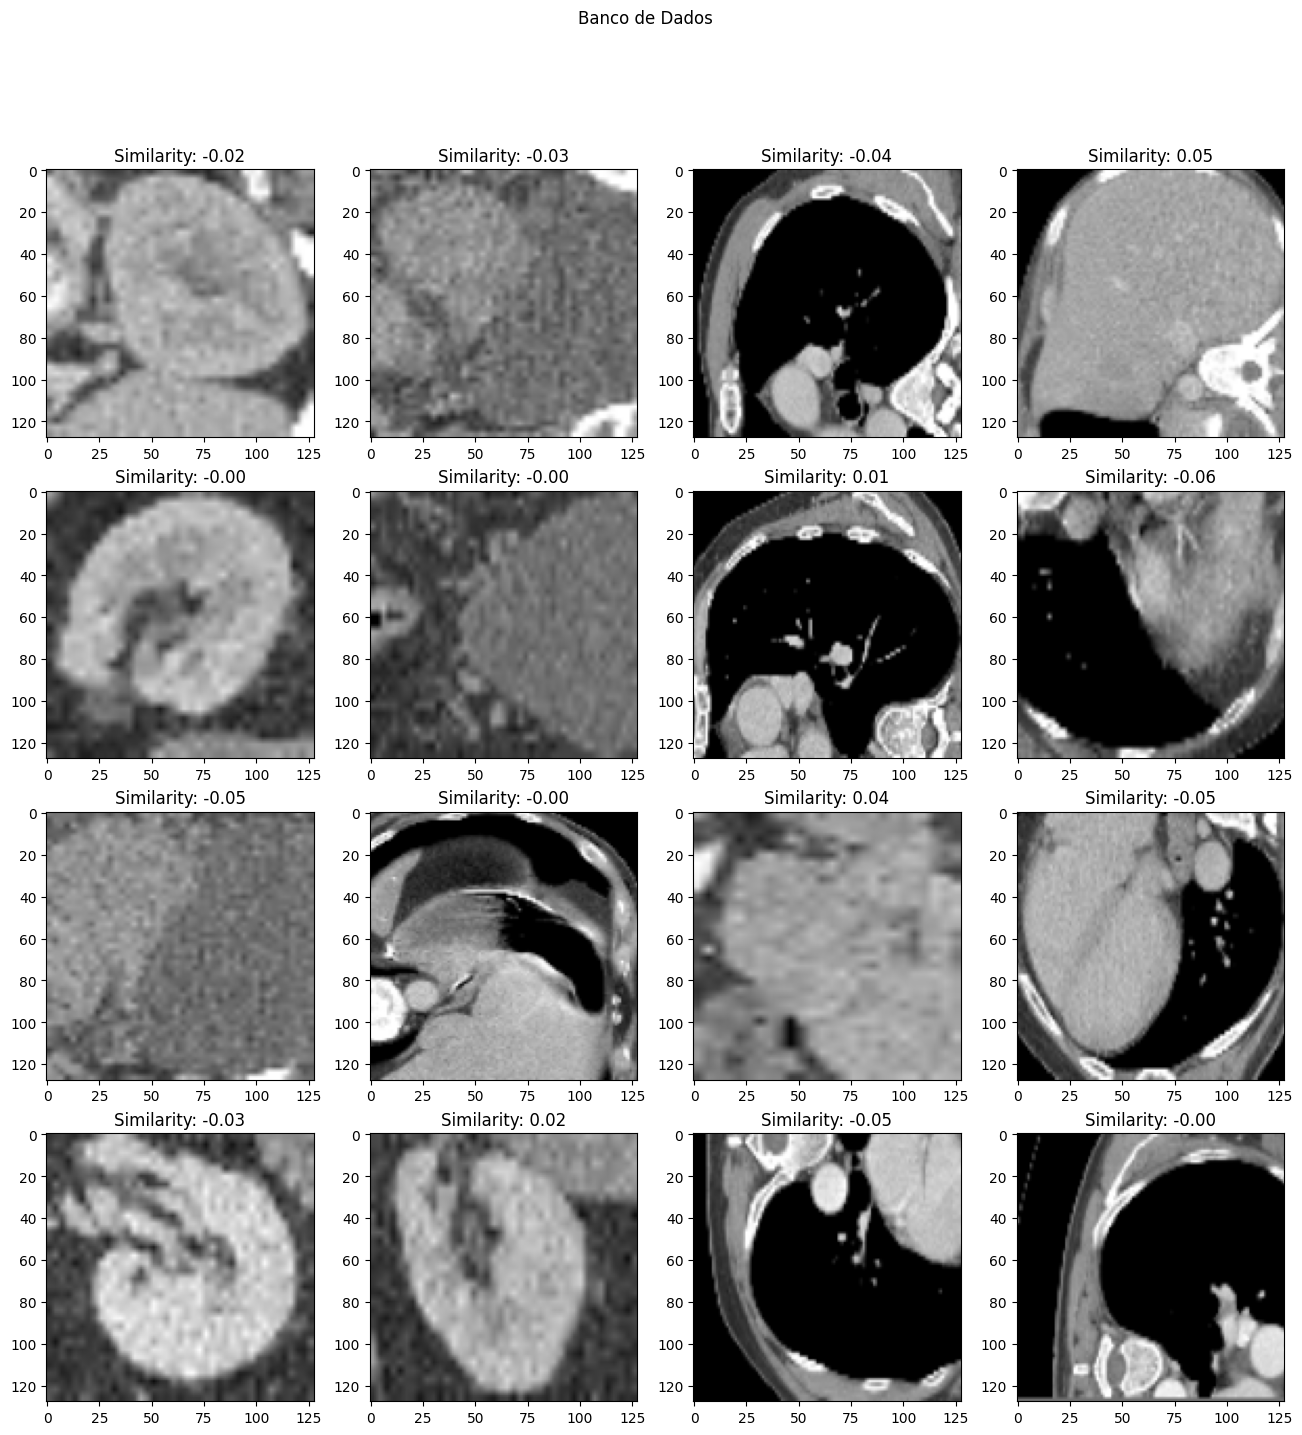

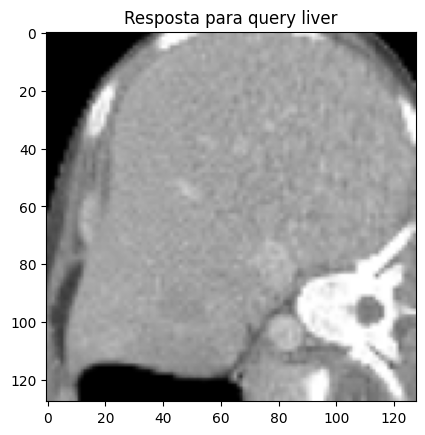

In [ ]:
# Denormalizar as imagens para visualização após predict
MEAN, STD = torch.tensor(OrganMNISTDataModule.MEAN).view(1, 1, 1, 1), torch.tensor(OrganMNISTDataModule.STD).view(1, 1, 1, 1)

query = "liver"
iter_dl = iter(query_dataloader)
sample_batch = torch.cat([next(iter_dl)["image"] for _ in range(4)], dim=0)
similarity, index = lightning_module.query(query, sample_batch)

denormalized_images = (sample_batch * STD) + MEAN

plt.figure(figsize=(16, 16))
plt.suptitle("Banco de Dados")
side = math.isqrt(len(denormalized_images))
for i, image in enumerate(denormalized_images):
    plt.subplot(side, side, i + 1)
    plt.imshow(image.permute(1, 2, 0))
    plt.title(f"Similarity: {similarity[i].item():.2f}")

plt.figure()
plt.imshow(denormalized_images[index].permute(1, 2, 0))
plt.title(f"Resposta para query {query}")
plt.show()